In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
from FRVRS import nu, fu


# Develop the Euclidean Distance to Last Engagement Metric

In [3]:

# Get all CSVs into one data frame
frvrs_logs_df = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df')['frvrs_logs_df']
print(frvrs_logs_df.shape)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
(829116, 114)



## Develop an Ideal Order of Engagement

In [4]:

import math

def get_clusters_dictionary(tuples_list, verbose=False):
    
    # Separate tuples based on cluster ID
    clusters_dict = {}
    for patient_id, engagement_start, location_tuple, patient_sort in tuples_list:
        if patient_sort not in clusters_dict: clusters_dict[patient_sort] = []
        engagement_tuple = (patient_id, engagement_start, location_tuple, patient_sort)
        clusters_dict[patient_sort].append(engagement_tuple)
    if verbose: print(f'\n\nclusters_dict: {clusters_dict}')
    
    return clusters_dict

def get_ideal_engagement_order(scene_df, tuples_list=None, verbose=False):
    
    # Create the patient sort tuples list
    if tuples_list is None: tuples_list = fu.get_engagement_starts_order(scene_df, verbose=verbose)
    
    # Separate tuples based on cluster ID
    clusters = get_clusters_dictionary(tuples_list, verbose=verbose)
    
    # Get initial player location
    mask_series = (scene_df.action_type == 'PLAYER_LOCATION')
    if mask_series.any(): player_location = eval(scene_df[mask_series].sort_values('action_tick').iloc[0].location_id)
    else: player_location = (0.0, 0.0, 0.0)
    player_location = (player_location[0], player_location[2])
    
    # Go from nearest neighbor to nearest neighbor by cluster
    ideal_engagement_order = []
    for cluster_id in ['still', 'waver', 'walker']:
        
        # Get locations list
        locations_list = [x[2] for x in clusters[cluster_id]]
        
        # Pop the nearest neighbor off the locations list and add it to the engagement order
        # Assume no patients are in the exact same spot
        while locations_list:
            nearest_neighbor = nu.get_nearest_neighbor(player_location, locations_list)
            nearest_neighbor = locations_list.pop(locations_list.index(nearest_neighbor))
            for patient_sort_tuple in clusters[cluster_id]:
                if (patient_sort_tuple[2] == nearest_neighbor):
                    ideal_engagement_order.append(patient_sort_tuple)
                    break
            player_location = nearest_neighbor
        
    if verbose: print(f'\n\nideal_engagement_order: {ideal_engagement_order}')
    
    return ideal_engagement_order

In [5]:

from pandas import DataFrame

mask_series = (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
scene_gb = frvrs_logs_df[mask_series].groupby(fu.scene_groupby_columns).filter(lambda df: df.patient_id.nunique() == 11).groupby(fu.scene_groupby_columns)
rows_list = []
columns_list = ['patient_id', 'engagement_start', 'location_tuple', 'patient_sort']
for (session_uuid, scene_id), scene_df in scene_gb:
    row_dict = {}
    for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    
    actual_engagement_order = fu.get_engagement_starts_order(scene_df, verbose=False)
    
    # Get last still engagement and subtract the scene start
    df = DataFrame(actual_engagement_order, columns=columns_list)
    mask_series = (df.patient_sort == 'still')
    last_still_engagement = df[mask_series].engagement_start.max()
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
    row_dict['last_still_engagement'] = last_still_engagement - fu.get_scene_start(frvrs_logs_df[mask_series])
    
    actual_engagement_distance = sum([
        math.sqrt(
            (first_tuple[2][0] - last_tuple[2][0])**2 + (first_tuple[2][1] - last_tuple[2][1])**2
        ) for first_tuple, last_tuple in zip(actual_engagement_order[:-1], actual_engagement_order[1:])
    ])
    row_dict['actual_engagement_distance'] = actual_engagement_distance
    
    ideal_engagement_order = get_ideal_engagement_order(scene_df, tuples_list=actual_engagement_order, verbose=False)
    ideal_engagement_distance = sum([
        math.sqrt(
            (first_tuple[2][0] - last_tuple[2][0])**2 + (first_tuple[2][1] - last_tuple[2][1])**2
        ) for first_tuple, last_tuple in zip(ideal_engagement_order[:-1], ideal_engagement_order[1:])
    ])
    row_dict['ideal_engagement_distance'] = ideal_engagement_distance
    
    row_dict['engagement_distance_delta'] = actual_engagement_distance - ideal_engagement_distance
    rows_list.append(row_dict)
distance_delta_df = DataFrame(rows_list)


This more subtle Ideal Engagement Order ends up being compared, sometimes, to the Actual Engagement Order of a responder who engaged a walker before telling all patients who can walk to move to the safe area. So you get this weird bimodal distribution:

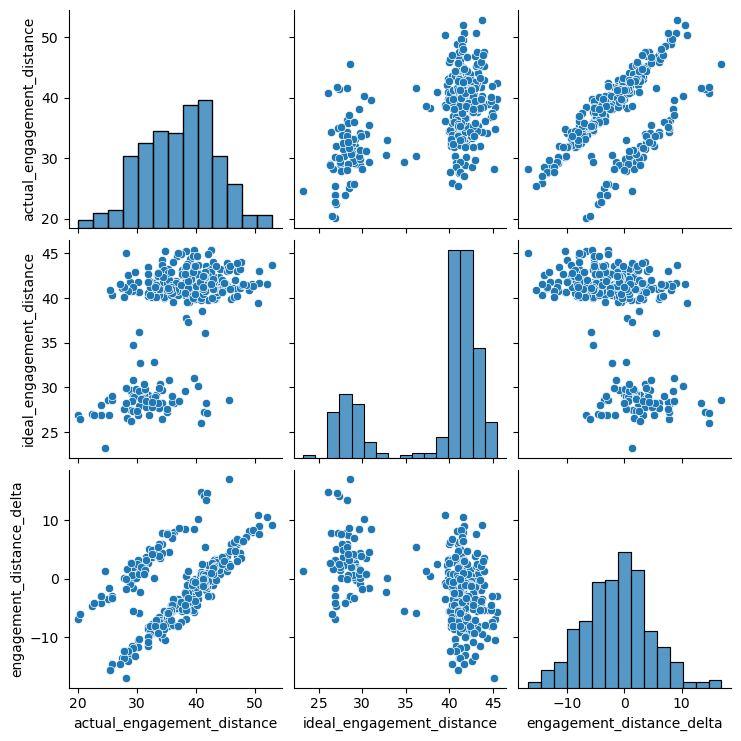

In [6]:

import seaborn as sns

columns_list = ['actual_engagement_distance', 'ideal_engagement_distance', 'engagement_distance_delta']
PairGrid_obj = sns.pairplot(distance_delta_df[columns_list])


The larger mode is responders who have moved the walkers previous to engaging with them. The smaller mode is where the ideal is wrongly computed because the walkers are only where they were first engaged, and therefore at a closer distance to the wavers.

In [7]:

df = distance_delta_df.sort_values('engagement_distance_delta')


### Here is an example where the ideal has a larger Euclidean footprint than the actual.

In [8]:

session_uuid = df.iloc[0].session_uuid
scene_id = df.iloc[0].scene_id
mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id)
scene_df = frvrs_logs_df[mask_series]
color_dict = {
    'Gary_3 Root': '#a6cee3', 'Mike_7 Root': '#1f78b4', 'Gloria_6 Root': '#b2df8a', 'Bob_0 Root': '#33a02c', 'Lily_4 Root': '#fb9a99',
    'Gary_1 Root': '#fdbf6f', 'Gary_9 Root': '#ff7f00', 'Lily_2 Root': '#cab2d6', 'Mike_5 Root': '#6a3d9a', 'Gloria_8 Root': '#bbbb00', 'Helga_10 Root': '#b15928'
}


Does a walker still move to the safe area if all patients are first told to move _after_ this particular patient has been engaged? I don't think so. It looks like the first time the command was logged, nobody moved, then the first walker was engaged, then the rest of the walkers moved _after_ the second command was logged.

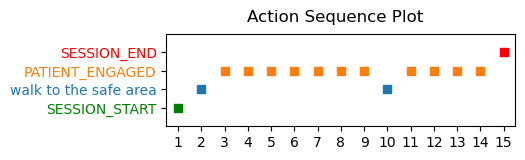

In [9]:

# Plot what the actions look like
import humanize

summary_statistics_df = nu.load_object('summary_statistics_df')
time_groups_dict = nu.load_object('time_groups_dict')
alphabet_list = ['SESSION_START', 'walk to the safe area', 'PATIENT_ENGAGED', 'SESSION_END']
actions_mask_series = frvrs_logs_df.action_type.isin(alphabet_list)
actions_mask_series |= ((frvrs_logs_df.action_type == 'VOICE_COMMAND') & frvrs_logs_df.voice_command_message.isin(alphabet_list))
scene_tuple = (session_uuid, scene_id)
sequence = [s for s in time_groups_dict[scene_tuple] if s in alphabet_list]
title = f'Action Sequence Plot for UUID {session_uuid} ({humanize.ordinal(scene_id+1)} Scene)'
title = f'Action Sequence Plot'
fig, ax = fu.plot_sequence_by_scene_tuple(
    scene_tuple, sequence, summary_statistics_df=summary_statistics_df, frvrs_logs_df=frvrs_logs_df, actions_mask_series=actions_mask_series,
    suptitle=title, verbose=False
)


Here's the actual:

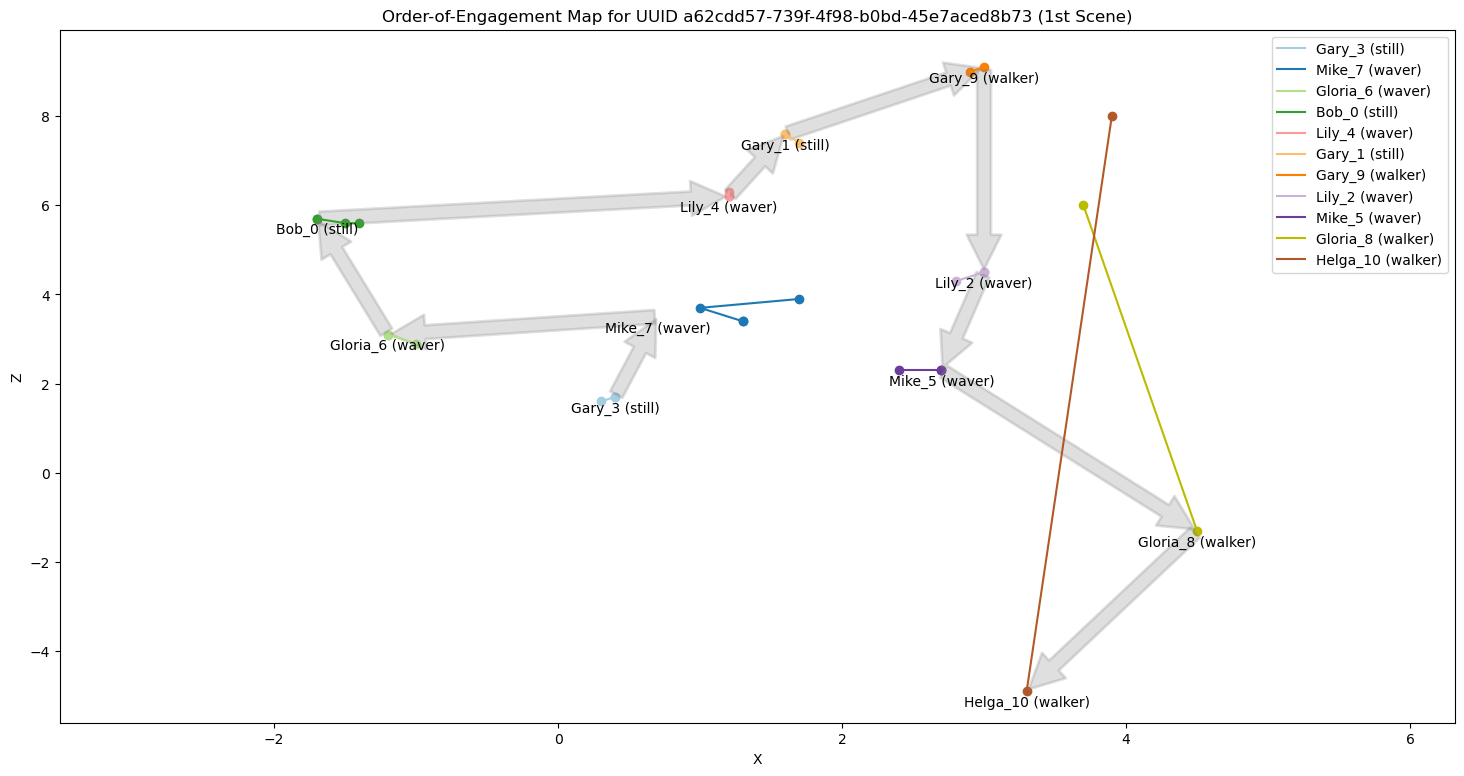

In [11]:

fig, ax = fu.visualize_order_of_engagement(scene_df, engagement_order=None, color_dict=color_dict, verbose=False)


Here's the ideal:

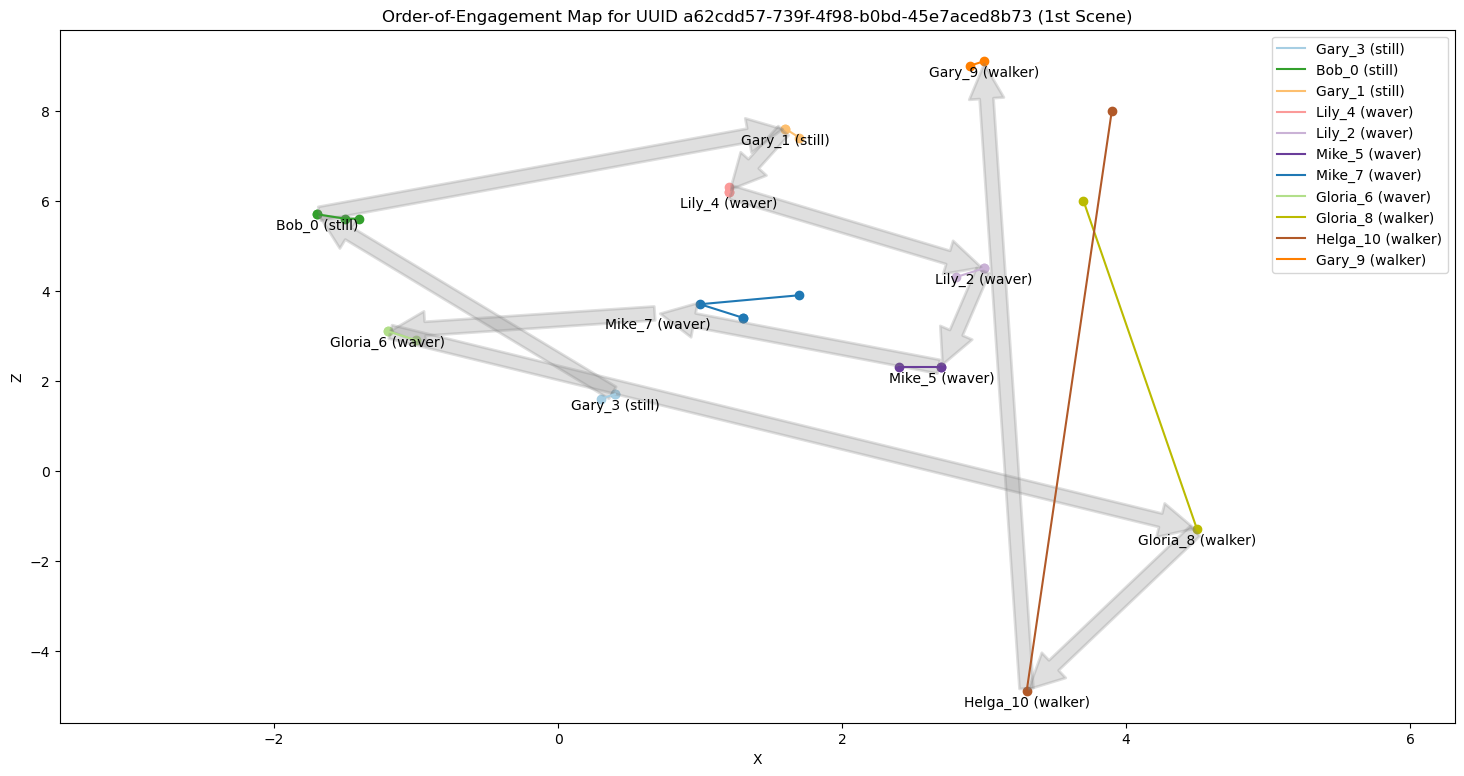

In [12]:

fig, ax = fu.visualize_order_of_engagement(scene_df, engagement_order=get_ideal_engagement_order(scene_df), color_dict=color_dict)


### Here is an example where the actual has a larger Euclidean footprint than the ideal.

In [13]:

mask_series = (frvrs_logs_df.session_uuid == df.iloc[-1].session_uuid) & (frvrs_logs_df.scene_id == df.iloc[-1].scene_id)
scene_df = frvrs_logs_df[mask_series]
color_dict = {
    'Lily_7 Root': '#a6cee3', 'Mike_6 Root': '#1f78b4', 'Gloria_8 Root': '#b2df8a', 'Helga_0 Root': '#33a02c', 'Mike_3 Root': '#fb9a99',
    'Lily_1 Root': '#fdbf6f', 'Gloria_2 Root': '#ff7f00', 'Mike_9 Root': '#cab2d6', 'Gary_5 Root': '#6a3d9a', 'Bob_10 Root': '#bbbb00', 'Bob_4 Root': '#b15928'
}


Here's the actual:

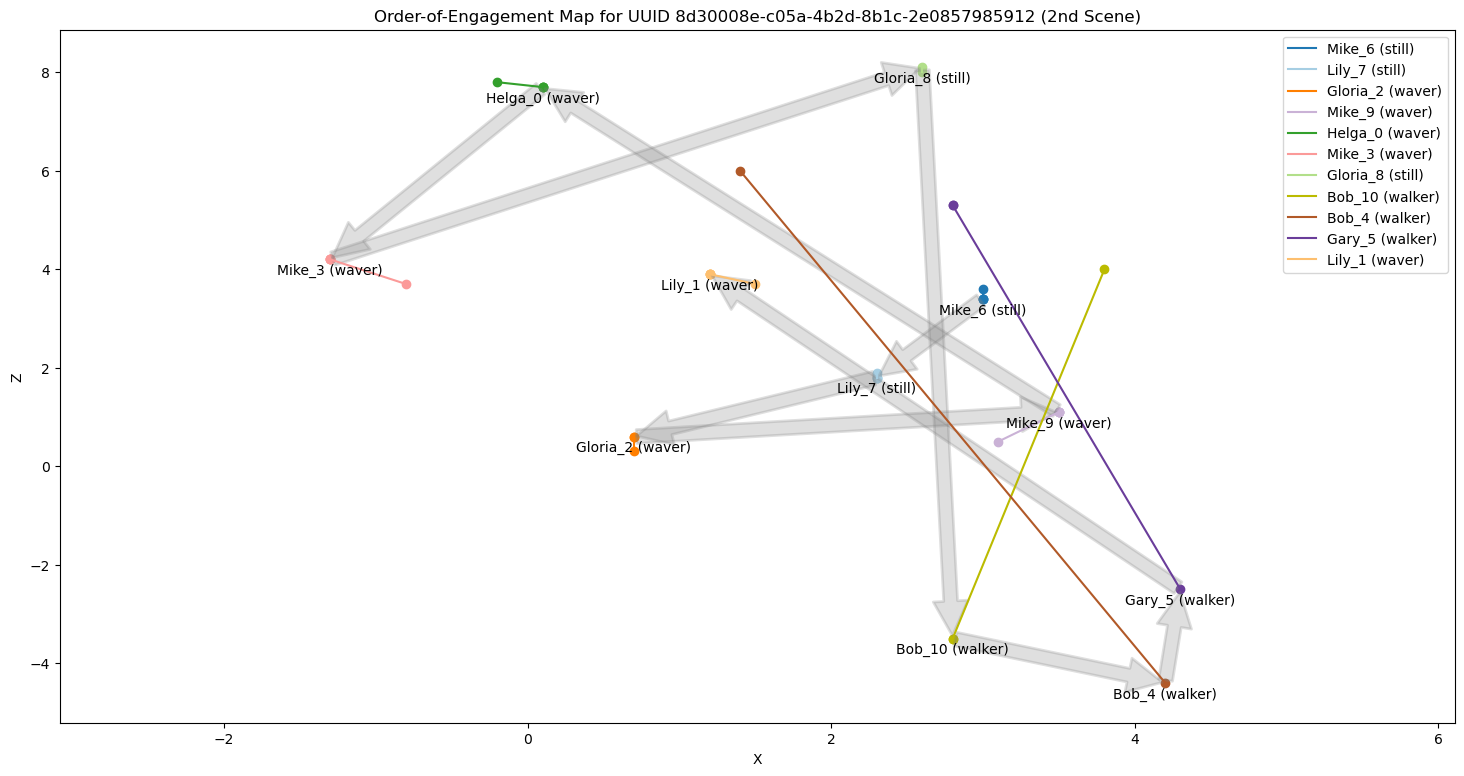

In [14]:

fig, ax = fu.visualize_order_of_engagement(scene_df, engagement_order=None, color_dict=color_dict, verbose=False)


Here's the ideal:

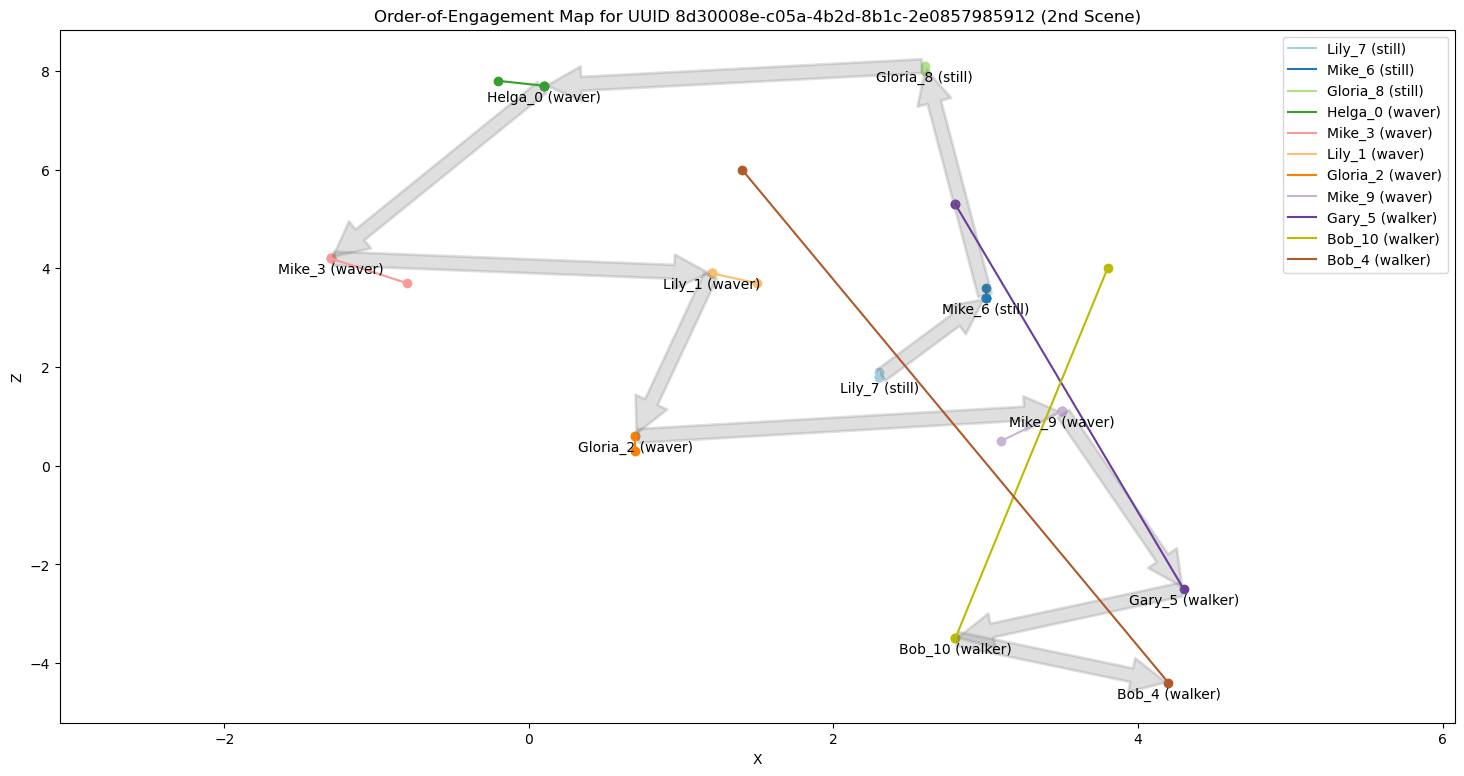

In [15]:

fig, ax = fu.visualize_order_of_engagement(scene_df, engagement_order=get_ideal_engagement_order(scene_df), color_dict=color_dict)


## In looking at the maps, does a small footprint correlate to efficient performance?


Here's a better scatterplot than the original, using my new Ideal Ordering. The negative deltas are an improvement of the ideal ordering over the actual ordering:

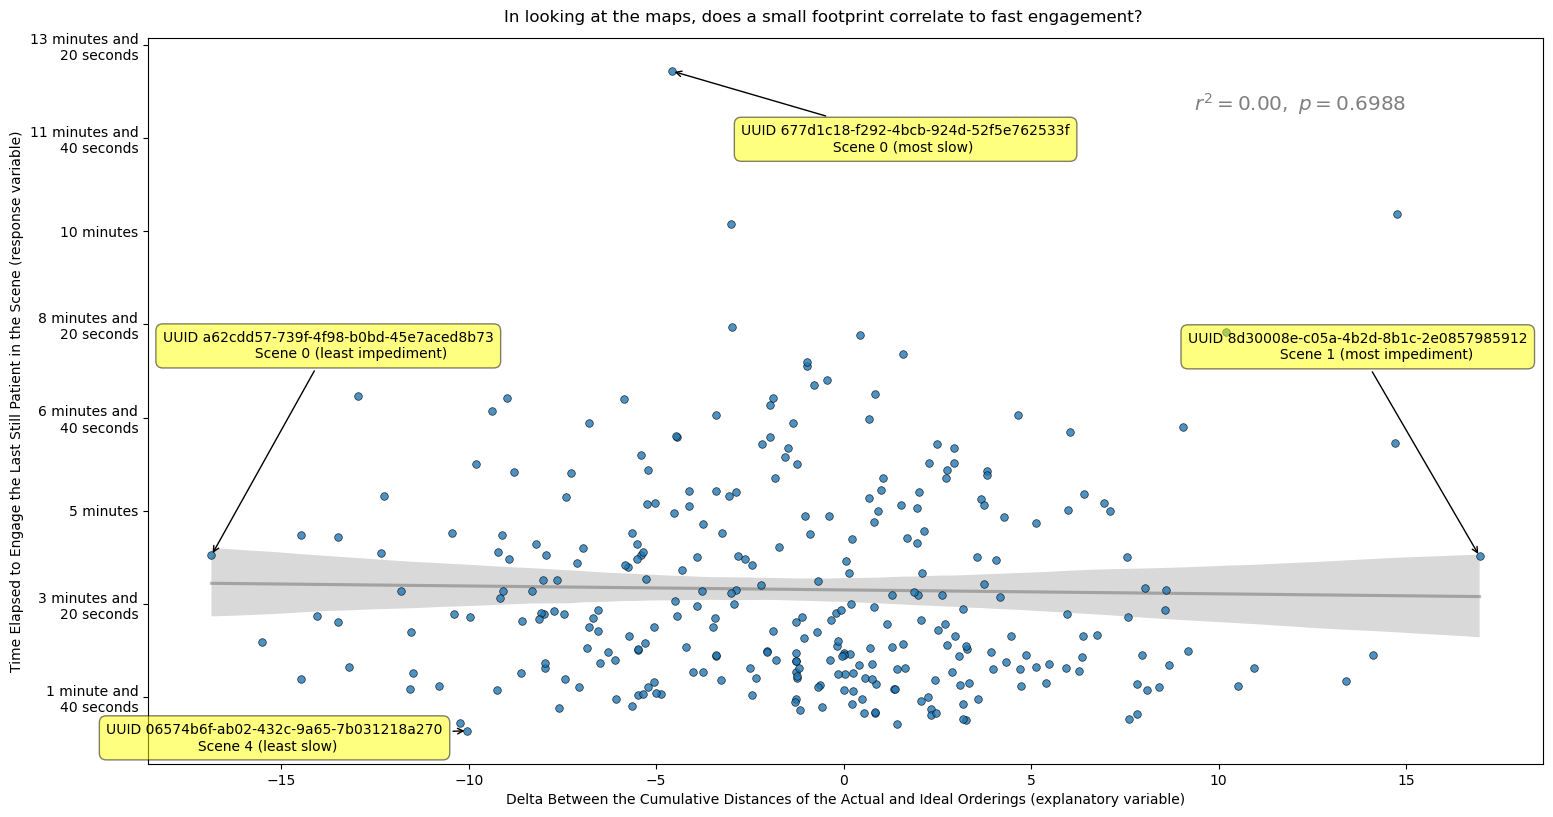

In [12]:

# Distance travelled and efficiency vs accuracy
# (ie in looking at the maps, does a small footprint correlate to efficient performance?)
import pandas as pd
from datetime import timedelta

df = distance_delta_df.set_index(fu.scene_groupby_columns)
df.index = pd.Index([f'UUID {idx_tuple[0]}\n                     Scene {idx_tuple[1]}' for idx_tuple in df.index.tolist()])
fig = nu.first_order_linear_scatterplot(
    df,
    'engagement_distance_delta',
    'last_still_engagement',
    xlabel_str='Delta Between the Cumulative Distances of the Actual and Ideal Orderings (explanatory variable)',
    ylabel_str='Time Elapsed to Engage the Last Still Patient in the Scene (response variable)',
    x_adj='impediment',
    y_adj='slow',
    title='In looking at the maps, does a small footprint correlate to fast engagement?',
    idx_reference=None,
    annot_reference=None,
    aspect_ratio=None,
    least_x_xytext=(-35, 140),
    most_x_xytext=(-210, 140),
    least_y_xytext=(-260, -16),
    most_y_xytext=(50, -60),
    reference_xytext=None,
    color_list=None,
)
ax = fig.get_axes()[0]

# Humanize y tick labels; why you have to set them twice (I do not know)
ax.set_yticklabels([text_obj for text_obj in ax.get_yticklabels()]);
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_position = text_obj.get_position()[1]
    time_delta = timedelta(milliseconds=text_position)
    precise_delta = humanize.precisedelta(time_delta)
    text_obj.set_text(precise_delta.replace(', ', ',\n').replace(' and ', ' and\n'))
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list);